<a href="https://colab.research.google.com/github/DiasKhalniyasov/Early-Exit-model-on-caltech101/blob/main/EarlyExit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: Dias Khalniyasov

**Matricola**: 1954228

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

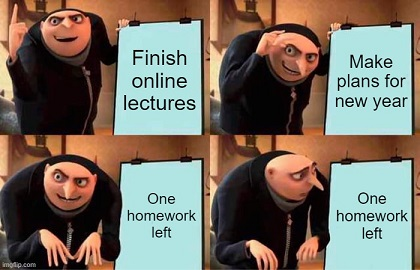

In [ ]:
import tensorflow as tf

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

For dataset I chose caltech 101, that consists of pictures of objects belonging to 101 classes, plus one background clutter class. Each image is labelled with a single object. More info: https://www.tensorflow.org/datasets/catalog/caltech101
I load the data, and split in train-validation-test (60-20-20 ratio).

For preprocessing I resize them in (256,256), shuffle and split on batches

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time

In [ ]:
import tensorflow_datasets as tfds
test_set, valid_set, train_set = tfds.load("caltech101",split=["test", "train[0%:20%]", "train[20%:]"],
                                           as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.1.incompleteRYX0Z8/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.1.incompleteRYX0Z8/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def format_example(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (256, 256))
    return image, label


batch_size = 32

train_set = train_set.map(format_example).shuffle(buffer_size=1024).map(lambda x, y: (x, tf.one_hot(y, depth=102)))
valid_set = valid_set.map(format_example).shuffle(buffer_size=1024).map(lambda x, y: (x, tf.one_hot(y, depth=102)))
test_set = test_set.map(format_example).map(lambda x, y: (x, tf.one_hot(y, depth=102)))

In [ ]:
ds_train_batch = train_set.prefetch(buffer_size=tf.data.AUTOTUNE).batch(32)
ds_test_batch = test_set.prefetch(buffer_size=tf.data.AUTOTUNE).batch(1)
ds_val_batch = valid_set.prefetch(buffer_size=tf.data.AUTOTUNE).batch(32)


### Part 1: Training simple neural network

In this part we just train classification model and evaluate speed of inference.

For the model I decided to use simple convolutional neural network with maxpools and dropout.
The task is to be able to classify images, given in the dataset.

Added:

1. Reducing Learning Rate if validation loss is on plateau   
2. Early Stopping if the model is not decreasing on validation
3. Dropout for regularization
4. Maxpooling for reducing the size of tensors
5. Model Checkpoint to save the best model

For metrics: 'accuracy'
for optimizer: 'adam'

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).
img_size = 256
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 32, padding = "same",
                           input_shape = (img_size, img_size, 3)),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 32, padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 64, padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 64, padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(102, activation = "softmax")
])

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import time
import timeit
from keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from tqdm.notebook import tqdm

num_epochs = 50
metric = ["accuracy",
           Precision(name = "Precision"),
           Recall(name = "Recall"),
           F1Score(num_classes = 102, threshold = 0.5)]
loss_ = keras.losses.CategoricalCrossentropy()

model.compile(loss = loss_,
              optimizer = "adam",
              metrics = metric)
checkpoint  = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor = "val_loss", save_best_only = True, mode = "min", verbose = 1)
early_stop  = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)
reduce_lr   = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 5, min_delta = 0.05,
                                                   mode = "auto", verbose = 1)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# You can train using fit() or a custom training loop, equivalently.
# I use fit for simplicity

start = timeit.default_timer()
history_model = model.fit(ds_train_batch, epochs = num_epochs, verbose = 1, callbacks = [checkpoint, early_stop, reduce_lr], validation_data = ds_val_batch)

stop = timeit.default_timer()
print("Computational Time:", stop - start)

Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 4.7507 - accuracy: 0.0127 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 1: val_loss improved from inf to 4.59977, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 35s 173ms/step - loss: 4.7507 - accuracy: 0.0127 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 4.5998 - val_accuracy: 0.0245 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 4.6260 - accuracy: 0.0180 - Precision: 1.0000 - Recall: 8.1699e-04 - f1_score: 0.0016
Epoch 2: val_loss improved from 4.59977 to 4.57079, saving model to model.h5
77/77 [==============================] - 7s 77ms/step - loss: 4.6260 - accuracy: 0.0180 - Precision: 1.0000 - Recall: 8.1699e-04 - f1_score: 0.0016 - val_loss: 4.5708 - val_accuracy: 0.0229 - val_Precision: 1.0000 - val_Recall: 0.0016 - val_f1_score: 0.0025 - lr: 0.0010
Epoch 3/50
76/77 [============================>.] - ETA: 0s - loss: 4.5787 - accuracy: 0.0284 - Precision: 0.1667 - Recall: 4.1118e-04 - f1_score: 7.8431e-04
Epoch 3: val_loss improved from 4.57079 to 4.47

Let's evaluate our model on test dataset, and calculate average time spent on inference

In [ ]:
model.evaluate(ds_test_batch)

6084/6084 [==============================] - 47s 8ms/step - loss: 2.0978 - accuracy: 0.5791 - Precision: 0.8208 - Recall: 0.4952 - f1_score: 0.3346


[2.0977625846862793,
 0.5790598392486572,
 0.820757269859314,
 0.4952333867549896,
 array([0.59090906, 0.8838528 , 0.31578946, 0.11764707, 0.09913793,
        0.        , 0.06896552, 0.11111111, 0.16666667, 0.14414413,
        0.29213485, 0.22222222, 0.35955057, 0.16666667, 0.2777778 ,
        0.        , 0.8342857 , 0.0952381 , 0.7352941 , 0.10810811,
        0.45454544, 0.08695652, 0.13333334, 0.        , 0.08510638,
        0.        , 0.14285715, 0.06896552, 0.13043478, 0.7317073 ,
        0.48275864, 0.5846154 , 0.42105263, 0.05714286, 0.        ,
        0.64516133, 0.33802813, 0.5100182 , 0.9689441 , 0.34920636,
        0.22727272, 0.22222224, 0.14285715, 0.        , 0.2580645 ,
        0.81967217, 0.45999998, 0.1       , 0.43243247, 0.16438356,
        0.09836065, 0.15384616, 0.23076923, 0.16216217, 0.58823526,
        0.25641024, 0.5526316 , 0.8853503 , 0.16393444, 0.1       ,
        0.13043478, 0.47619048, 0.14285715, 0.7254902 , 0.15384614,
        0.8235294 , 0.9391661 , 0

In [ ]:
inference_times = []
correct_predictions = 0
total_predictions = 0

for batch in ds_test_batch:
    start_time = time.time()

    # Unpack the batch into separate inputs
    input_1 = batch[0]  # Assuming the first input tensor is required
    input_2 = batch[1]  # Assuming the second input tensor is required

    # Perform inference on the batch
    predictions  = model.predict(input_1)

    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)
    # Count correct predictions
    predicted_labels = tf.argmax(predictions, axis=1)
    true_labels = tf.argmax(input_2, axis=1)
    correct_predictions += tf.reduce_sum(tf.cast(tf.equal(predicted_labels, true_labels), tf.int32))
    total_predictions += input_2.shape[0]

# Calculate the average inference time
average_inference_time = sum(inference_times) / len(inference_times)

print("Average inference time:", average_inference_time)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
Average inference time: 0.07665362626921574


Here I wrote custom evaluate function with 'model.predict' to identify average inference time.
Let's note the results for later comparison:


---



**Average inference time: 0.07926086114473362**

**accuracy: 0.5462 - Precision: 0.8080 - Recall: 0.4760 - f1_score: 0.3392**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Save model
model.save_weights('/content/gdrive/MyDrive/checkpoints/my_checkpoint')


### Part 2: Adding modularity to the network

The purpose is to implement a "modular" network with **Early-exits**
We modify the model by adding 3 early exits and train it.

After training we will evaluate new model on test dataset, and compare accuracy and average inference time with existing results

For training I wrote custom class by inheriting tf.keras.Model.
We add Early-Exit layers after each conv-maxpool layer.

We also add early stopping and reducinglr in the custom training loop


In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.
class EarlyExit(tf.keras.Model):
    def __init__(self, threshold, exits, img_size=256):
        super(EarlyExit, self).__init__()
        self.threshold = threshold
        self.exits = exits
        self.loss_ = tf.keras.losses.CategoricalCrossentropy()
        self.all_layers =  tf.keras.Sequential([
            # 1 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 32, padding = "same",
                                  input_shape = (img_size, img_size, 3)),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            # 2 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 32, padding = "same"),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            # 3 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 64, padding = "same"),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            # 4 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 64, padding = "same"),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            ## Output Layer
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation = "relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation = "relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(102, activation = "softmax")
        ])

        self.classifiers = [tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(102, activation = "softmax")]) for _ in exits]

    def call(self, inputs, training = None, labels = None):
        outputs = []
        count_ = 0

        # Iterate over layers
        x = inputs
        for i, layer in enumerate(self.all_layers.layers):
            x = layer(x)
            if i in self.exits:
                output = self.classifiers[count_](x) # On the exit layers run the classifier
                outputs.append(output)
                if training == False:
                    return tf.cond(tf.reduce_any(tf.reduce_max(output, axis=1) > self.threshold),
                               lambda: [output],  # Wrap output in a list
                               lambda: outputs)
                count_ += 1

            if i == 13:
                outputs.append(x)

        return outputs

## Call the class
exit_model = EarlyExit(exits = [2, 5, 8], threshold = 0.5)

In [ ]:
@tf.function
def train_step(inputs,targets,model,optimizer,loss_,loss_metric
               ,total_acc,exit1_acc,exit2_acc,exit3_acc):
    '''
    Run training, add exit accuracy
    '''
    with tf.GradientTape() as tape:
        outputs = model(inputs, training=True)
        loss = loss_(targets, outputs)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    final_loss = loss_metric(loss)

    total_acc.update_state(targets, outputs[-1])
    exit1_acc.update_state(targets, outputs[0])
    exit2_acc.update_state(targets, outputs[1])
    exit3_acc.update_state(targets, outputs[2])


@tf.function
def test_step(inputs, targets,model,loss_,loss_metric):
    logits = model(inputs, training=False)

    val_acc_metric.update_state(targets, logits[-1])
    val_loss_metric.update_state(targets, logits[-1])


In [ ]:
optimizer = tf.keras.optimizers.Adam()
epochs    = 50

# Defining losses for exits, training and validation
cat_crossentropy_loss       = tf.keras.losses.CategoricalCrossentropy()
loss_metric = tf.keras.metrics.Mean()
val_acc_metric = keras.metrics.CategoricalAccuracy()
val_loss_metric = tf.keras.metrics.CategoricalCrossentropy()
final_acc   = keras.metrics.CategoricalAccuracy()
ee1_acc     = keras.metrics.CategoricalAccuracy()
ee2_acc     = keras.metrics.CategoricalAccuracy()
ee3_acc     = keras.metrics.CategoricalAccuracy()

## Define list in which to save the partial accuracies for Early Exit
losses_list = []
final_accs  = []
ee1_accs    = []
ee2_accs    = []
ee3_accs    = []

# Sum of all losses = final_loss
def custom_loss(y_true, y_pred):
  loss_1 = cat_crossentropy_loss(y_true, y_pred[0])
  loss_2 = cat_crossentropy_loss(y_true, y_pred[1])
  loss_3 = cat_crossentropy_loss(y_true, y_pred[2])
  loss_model = cat_crossentropy_loss(y_true, y_pred[-1])
  final_loss = loss_1 + loss_2 + loss_3 + loss_model
  return final_loss

In [ ]:
import timeit
patience_lr=5
patience_stop = 10
wait =0
best = float('inf')
factor = 0.3
epochs_since_last_improvement=0
start = timeit.default_timer()

# Start the custom training loop
for epoch in tqdm(range(epochs)):
    print("\nStart of epoch %d" % (epoch))

    for step, (inputs, targets) in enumerate(ds_train_batch):
        train_step(inputs, targets, exit_model, optimizer, custom_loss, loss_metric, final_acc, ee1_acc, ee2_acc, ee3_acc)


    print("Loss:", float(loss_metric.result()))
    losses_list.append(loss_metric.result())

    ## Print the final accuracies
    print("Accuracy over epoch: %.4f" % (float(final_acc.result()),))
    print("Early Exit 1 over epoch acc: %.4f" % (float(ee1_acc.result()),))
    print("Early Exit 2 over epoch acc: %.4f" % (float(ee2_acc.result()),))
    print("Early Exit 3 over epoch acc: %.4f" % (float(ee3_acc.result()),))

    final_accs.append(final_acc.result())
    ee1_accs.append(ee1_acc.result())
    ee2_accs.append(ee2_acc.result())
    ee3_accs.append(ee3_acc.result())

    for inputs_val, targets_val in ds_val_batch:
          test_step(inputs_val, targets_val,exit_model, custom_loss, loss_metric)

    val_acc = val_acc_metric.result()
    val_loss = val_loss_metric.result()

    print("Val loss: %.4f" % (float(val_loss),))
    print("Validation acc: %.4f" % (float(val_acc),))
    ## Reset metrics for the next epoch
    loss_metric.reset_states()
    final_acc.reset_states()
    ee1_acc.reset_states()
    ee2_acc.reset_states()
    ee3_acc.reset_states()
    val_acc_metric.reset_states()
    val_loss_metric.reset_states()

    if epochs_since_last_improvement >= patience_lr:
      new_lr = factor * optimizer.learning_rate
      print(f'Reducing learning rate to {new_lr}.')
      optimizer.learning_rate.assign(new_lr)
      epochs_since_last_improvement = 0

    wait += 1
    if val_loss < best:
      best = val_loss
      wait = 0
      epochs_since_last_improvement = 0
    else:
      epochs_since_last_improvement += 1

    if wait >= patience_stop:
      break

stop = timeit.default_timer()
print("Computational Time:", stop - start)

  0%|          | 0/50 [00:00<?, ?it/s]


Start of epoch 0
Loss: 43.455101013183594
Accuracy over epoch: 0.0192
Early Exit 1 over epoch acc: 0.0650
Early Exit 2 over epoch acc: 0.1017
Early Exit 3 over epoch acc: 0.0833
Val loss: 7.6210
Validation acc: 0.1029

Start of epoch 1
Loss: 11.802258491516113
Accuracy over epoch: 0.0494
Early Exit 1 over epoch acc: 0.6777
Early Exit 2 over epoch acc: 0.4959
Early Exit 3 over epoch acc: 0.3407
Val loss: 5.7645
Validation acc: 0.1471

Start of epoch 2
Loss: 7.76097297668457
Accuracy over epoch: 0.1017
Early Exit 1 over epoch acc: 0.8942
Early Exit 2 over epoch acc: 0.7627
Early Exit 3 over epoch acc: 0.5891
Val loss: 5.3214
Validation acc: 0.1944

Start of epoch 3
Loss: 5.298120021820068
Accuracy over epoch: 0.1560
Early Exit 1 over epoch acc: 0.9477
Early Exit 2 over epoch acc: 0.9306
Early Exit 3 over epoch acc: 0.8395
Val loss: 6.0580
Validation acc: 0.1863

Start of epoch 4
Loss: 3.9065072536468506
Accuracy over epoch: 0.2263
Early Exit 1 over epoch acc: 0.9788
Early Exit 2 over ep

✍ **RESULTS AND EVALUATION**

In [ ]:
# TODO: Add results here (anything appropriate is okay).
import time
## Inference Time
test_acc = keras.metrics.CategoricalAccuracy()
time_on_inference = []
## Cycle
for step, (inputs, targets) in enumerate(ds_test_batch):
    start_time = time.time()

    output = exit_model(inputs, training = False)
    end_time = time.time()
    inference_time = end_time - start_time
    time_on_inference.append(inference_time)
    test_acc.update_state(targets, output)

print("Mean inference time:", sum(time_on_inference) / len(time_on_inference))
print("Accuracy on test set: %.4f" % (float(test_acc.result()),))
test_acc.reset_states()

Mean inference time: 0.0051813086814428925
Accuracy on test set: 0.4250


Now we calculate average inference time with EarlyExit model, and we can compare them

Convolutional model

**Average inference time: 0.08698961728501681**

**Accuracy on test set: 0.5695266272189349**



Adding EarlyExit

**Average inference time: 0.005546757063530214**

**Accuracy on test set: 0.4624**


We lose 10% in the accuracy but make inference time 16x faster !

In [ ]:
exit_model.save_weights('/content/gdrive/MyDrive/checkpoints/exit_checkpoint')

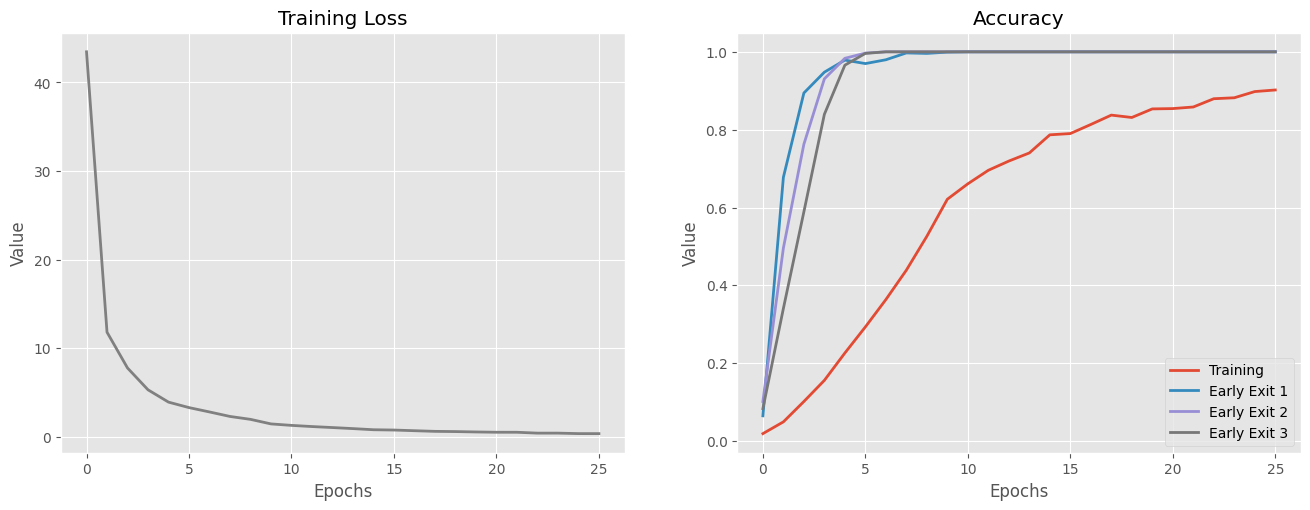

In [ ]:
# TODO: Add results here (anything appropriate is okay).

## Plot the average accuracy of each eatly exit
plt.style.use("ggplot")
plt.figure(figsize = (16, 12))

## Loss Plot
plt.subplot(221)
## Training Loss
plt.plot(losses_list, color = "grey", label = "Train", linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Loss")

## Accuracy Plot
plt.subplot(222)
## Train
plt.plot(final_accs,label = "Training", linewidth = 2)
plt.plot(ee1_accs, label = "Early Exit 1", linewidth = 2)
plt.plot(ee2_accs, label = "Early Exit 2", linewidth = 2)
plt.plot(ee3_accs, label = "Early Exit 3", linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
plt.legend(loc = "lower right")

plt.show()

### Load balancing regularization


For this exercise, you are asked to implement an additional **regularization term** as follows:

We add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).


In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.
# TODO: add all code here, using as many cells as you need. Train the new model.
class EarlyExit(tf.keras.Model):
    def __init__(self, threshold, exits, img_size=256):
        super(EarlyExit, self).__init__()
        self.threshold = threshold
        self.exits = exits
        self.loss_ = tf.keras.losses.CategoricalCrossentropy()
        self.exit_counters = [tf.Variable(0.0, trainable=False) for _ in exits]
        self.temperature = tf.Variable(1.0, trainable=True)
        self.all_layers =  tf.keras.Sequential([
            # 1 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 32, padding = "same",
                                  input_shape = (img_size, img_size, 3)),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            # 2 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 32, padding = "same"),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            # 3 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 64, padding = "same"),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            # 4 Layer
            tf.keras.layers.Conv2D(kernel_size = (3, 3) ,filters = 64, padding = "same"),
            tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

            ## Output Layer
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation = "relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation = "relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(102, activation = "softmax")
        ])

        self.classifiers = [tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(102, activation = "softmax")]) for _ in exits]

    def call(self, inputs, training = None, labels = None):
        outputs = []
        cnt = 0


        # Iterate over layers
        x = inputs
        for i, layer in enumerate(self.all_layers.layers):
            x = layer(x)
            if i in self.exits:
                output = self.classifiers[cnt](x) # On the exit layers run the classifier
                outputs.append(output)
                if training == False:
                    return tf.cond(tf.reduce_any(tf.reduce_max(output, axis=1) > self.threshold),
                               lambda: [output],  # Wrap output in a list
                               lambda: outputs)
                cnt += 1

            if i == 13:
                outputs.append(x)
        for i in range(len(outputs) - 1):  # -1 to exclude the final output
            self.exit_counters[i].assign_add(tf.reduce_sum(tf.cast(tf.reduce_max(outputs[i], axis=1) > self.threshold, tf.float32)))
        return outputs
    def infer(self, inputs):
        """Inference method that also tracks the early exits."""
        exit_counts = [0 for _ in self.exits]  # Initialize exit counters

        x = inputs
        for i, layer in enumerate(self.all_layers.layers):
            x = layer(x)
            if i in self.exits:
                output = self.classifiers[self.exits.index(i)](x)  # On the exit layers run the classifier
                if tf.reduce_any(tf.reduce_max(output, axis=1) > self.threshold):
                    exit_counts[self.exits.index(i)] += 1
                    return output, exit_counts  # Exit early
        return self.all_layers(inputs), exit_counts  # Return final output if no early exit
## Call the class
exit_model = EarlyExit(exits = [2, 5, 8], threshold = 0.5)


In [ ]:
@tf.function
def train_step(inputs,targets,model,optimizer,loss_,loss_metric
               ,total_acc,exit1_acc,exit2_acc,exit3_acc):
    '''
    Run training, add exit accuracy
    '''
    with tf.GradientTape() as tape:
        outputs = model(inputs, training=True)
        loss = loss_(targets, outputs)
        exit_distribution = tf.stack([tf.math.divide_no_nan(counter, tf.reduce_sum(model.exit_counters)) for counter in model.exit_counters])
        # Get exit distribution
        exit_logits = tf.stack([tf.math.divide_no_nan(counter, tf.reduce_sum(model.exit_counters)) for counter in model.exit_counters])
        # Calculate KL divergence
        kl_div = tf.keras.losses.kullback_leibler_divergence(exit_logits, tf.fill(exit_distribution.shape, 1.0 / len(model.exit_counters)))
        # Add KL divergence to loss
        loss = loss + kl_div

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    final_loss = loss_metric(loss)

    total_acc.update_state(targets, outputs[-1])
    exit1_acc.update_state(targets, outputs[0])
    exit2_acc.update_state(targets, outputs[1])
    exit3_acc.update_state(targets, outputs[2])


@tf.function
def test_step(inputs, targets,model,loss_,loss_metric):
    logits = model(inputs, training=False)

    val_acc_metric.update_state(targets, logits[-1])
    val_loss_metric.update_state(targets, logits[-1])


In [ ]:
## Define optimizer, number of epochs (best, using the Early Stopping in the point 1) and cross entropy loss
optimizer = tf.keras.optimizers.Adam()
epochs    = 50
cce       = tf.keras.losses.CategoricalCrossentropy()

## Define some useful functions
## 3 different early exits
loss_metric = tf.keras.metrics.Mean()
val_acc_metric = keras.metrics.CategoricalAccuracy()
val_loss_metric = tf.keras.metrics.CategoricalCrossentropy()
final_acc   = keras.metrics.CategoricalAccuracy()
ee1_acc     = keras.metrics.CategoricalAccuracy()
ee2_acc     = keras.metrics.CategoricalAccuracy()
ee3_acc     = keras.metrics.CategoricalAccuracy()

## Define list in which to save the partial accuracies for Early Exit
losses_list = []
final_accs  = []
ee1_accs    = []
ee2_accs    = []
ee3_accs    = []

## Define the loss function as the sum of the partial ones
def personal_loss(y_true, y_pred):
  loss_1 = cce(y_true, y_pred[0])
  loss_2 = cce(y_true, y_pred[1])
  loss_3 = cce(y_true, y_pred[2])
  loss_model = cce(y_true, y_pred[-1])

  final_loss = loss_1 + loss_2 + loss_3 + loss_model
  return final_loss

In [ ]:
import timeit
patience_lr=5
patience_stop = 10
wait =0
best = float('inf')
factor = 0.3
epochs_since_last_improvement=0
start = timeit.default_timer()

# Start the custom training loop
for epoch in tqdm(range(epochs)):
    print("\nStart of epoch %d" % (epoch))

    for step, (inputs, targets) in enumerate(ds_train_batch):
        train_step(inputs, targets, exit_model, optimizer, personal_loss, loss_metric, final_acc, ee1_acc, ee2_acc, ee3_acc)

    print("Loss:", float(loss_metric.result()))
    losses_list.append(loss_metric.result())

    ## Print the final accuracies
    print("Accuracy over epoch: %.4f" % (float(final_acc.result()),))
    print("Early Exit 1 over epoch acc: %.4f" % (float(ee1_acc.result()),))
    print("Early Exit 2 over epoch acc: %.4f" % (float(ee2_acc.result()),))
    print("Early Exit 3 over epoch acc: %.4f" % (float(ee3_acc.result()),))

    final_accs.append(final_acc.result())
    ee1_accs.append(ee1_acc.result())
    ee2_accs.append(ee2_acc.result())
    ee3_accs.append(ee3_acc.result())

    for inputs_val, targets_val in ds_val_batch:
          test_step(inputs_val, targets_val,exit_model, personal_loss, loss_metric)

    val_acc = val_acc_metric.result()
    val_loss = val_loss_metric.result()

    print("Val loss: %.4f" % (float(val_loss),))
    print("Validation acc: %.4f" % (float(val_acc),))
    ## Reset metrics for the next epoch
    loss_metric.reset_states()
    final_acc.reset_states()
    ee1_acc.reset_states()
    ee2_acc.reset_states()
    ee3_acc.reset_states()
    val_acc_metric.reset_states()
    val_loss_metric.reset_states()

    if epochs_since_last_improvement >= patience_lr:
      new_lr = factor * optimizer.learning_rate
      print(f'Reducing learning rate to {new_lr}.')
      optimizer.learning_rate.assign(new_lr)
      epochs_since_last_improvement = 0

    wait += 1
    if val_loss < best:
      best = val_loss
      wait = 0
      epochs_since_last_improvement = 0
    else:
      epochs_since_last_improvement += 1

    if wait >= patience_stop:
      break

stop = timeit.default_timer()
print("Computational Time:", stop - start)

  0%|          | 0/50 [00:00<?, ?it/s]


Start of epoch 0


Loss: 2.344832181930542
Accuracy over epoch: 0.7145
Early Exit 1 over epoch acc: 0.8150
Early Exit 2 over epoch acc: 0.9906
Early Exit 3 over epoch acc: 0.9984
Val loss: 7.6483
Validation acc: 0.1634

Start of epoch 1
Loss: 1.219652533531189
Accuracy over epoch: 0.7422
Early Exit 1 over epoch acc: 0.9551
Early Exit 2 over epoch acc: 0.9947
Early Exit 3 over epoch acc: 1.0000
Val loss: 8.3217
Validation acc: 0.1650

Start of epoch 2
Loss: 0.9076504111289978
Accuracy over epoch: 0.7945
Early Exit 1 over epoch acc: 0.9820
Early Exit 2 over epoch acc: 0.9963
Early Exit 3 over epoch acc: 1.0000
Val loss: 7.7733
Validation acc: 0.1552

Start of epoch 3
Loss: 0.8451706767082214
Accuracy over epoch: 0.7892
Early Exit 1 over epoch acc: 0.9796
Early Exit 2 over epoch acc: 0.9992
Early Exit 3 over epoch acc: 0.9996
Val loss: 8.2229
Validation acc: 0.1569

Start of epoch 4
Loss: 0.7778669595718384
Accuracy over epoch: 0.8027
Early Exit 1 over epoch acc: 0.9861
Early Exit 2 over epoch acc: 0.9984
E

KeyboardInterrupt: ignored

In [ ]:
# TODO: Add results here (anything appropriate is okay).
import time
## Inference Time
test_acc = keras.metrics.CategoricalAccuracy()
time_on_inference = []
## Cycle
for step, (inputs, targets) in enumerate(ds_test_batch):
    start_time = time.time()

    output = exit_model(inputs, training = False)
    end_time = time.time()
    inference_time = end_time - start_time
    time_on_inference.append(inference_time)
    test_acc.update_state(targets, output)

print("Mean inference time:", sum(time_on_inference) / len(time_on_inference))
print("Accuracy on test set: %.4f" % (float(test_acc.result()),))
test_acc.reset_states()

Mean inference time: 0.006350928588104749
Accuracy on test set: 0.4260


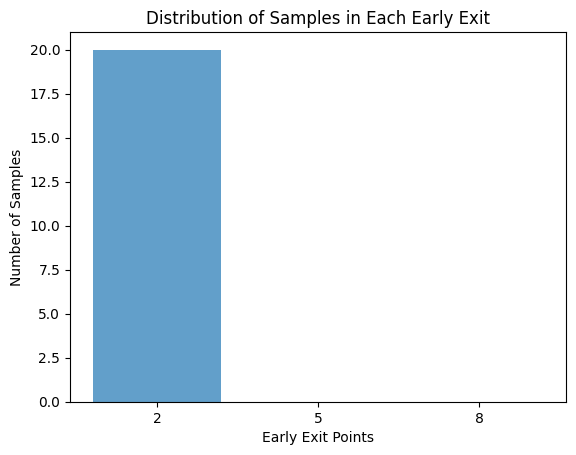

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

total_exit_counts = [0 for _ in exit_model.exits]

for inputs, _ in ds_val_batch:  # Or use your test set here
    _, exit_counts = exit_model.infer(inputs)
    total_exit_counts = [total + exit for total, exit in zip(total_exit_counts, exit_counts)]

# Create an array with the positions of each bar along the x-axis
x_pos = np.arange(len(exit_model.exits))

# Produce bar plot
plt.bar(x_pos, total_exit_counts, align='center', alpha=0.7)

# Add labels
plt.xlabel('Early Exit Points')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Each Early Exit')

# Change x-axis ticks to early exit points
plt.xticks(x_pos, exit_model.exits)

plt.show()
# doesnt work xd
# idk why